In [71]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt

In [72]:
# Load data (replace with your actual data loading)
data = pd.read_csv('../csv/TSLA_from_2021.csv', index_col='timestamp', parse_dates=True)

# Calculate returns
data['Return'] = data['close'].pct_change()

# Calculate volatility (30-day rolling standard deviation of returns)
data['Volatility'] = data['Return'].rolling(window=30).std()

# Simple Moving Average (50-day)
data['SMA_50'] = data['close'].rolling(window=50).mean()

# Drop missing values resulting from the calculations
data = data.dropna()

weekly = False

if weekly:
    weekly_data = data.resample('W').agg(agg_dict).dropna()

    # Now, recalculate features on this new weekly timeframe
    weekly_data['Return'] = weekly_data['close'].pct_change()
    weekly_data['Volatility'] = weekly_data['Return'].rolling(window=4).std() # e.g., 4-week (monthly) volatility
    weekly_data['SMA_10'] = weekly_data['close'].rolling(window=10).mean() # e.g., 10-week SMA

    data = weekly_data.dropna()

# Display the first few rows with the new features
print(data.head())


                          symbol      open      high     low   close  \
timestamp                                                              
2020-03-13 04:00:00+00:00   TSLA  595.0000  607.5700  502.00  546.62   
2020-03-16 04:00:00+00:00   TSLA  469.4997  494.8699  442.17  445.07   
2020-03-17 04:00:00+00:00   TSLA  440.0100  471.8500  396.00  430.20   
2020-03-18 04:00:00+00:00   TSLA  389.0000  404.8600  350.51  361.22   
2020-03-19 04:00:00+00:00   TSLA  374.6965  452.0000  358.46  427.64   

                               volume  trade_count        vwap    Return  \
timestamp                                                                  
2020-03-13 04:00:00+00:00  22899828.0     424899.0  539.134384 -0.024851   
2020-03-16 04:00:00+00:00  20941052.0     381026.0  465.049311 -0.185778   
2020-03-17 04:00:00+00:00  24340580.0     431552.0  429.358028 -0.033410   
2020-03-18 04:00:00+00:00  24132215.0     434985.0  374.883244 -0.160344   
2020-03-19 04:00:00+00:00  30528292.0  

In [73]:
from sklearn.preprocessing import QuantileTransformer

# Select features for the HMM
features = ['Return', 'Volatility', 'SMA_50']  # Example features
if weekly:
    features[2] = 'SMA_10'
X = data[features].values

# QuantileTransformer to map to a uniform distribution and then to discrete values
n_components = 3  # Example: 3 hidden states
quantizer = QuantileTransformer(n_quantiles=n_components, output_distribution='uniform', random_state=0)
X_quantized = quantizer.fit_transform(X)

# Initialize and train the HMM
model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", random_state=42)
model.fit(X_quantized)  # Use the quantized features


GaussianHMM(covariance_type='full', n_components=3, random_state=42)

State Means:
                 Return  Volatility      SMA_50
Hidden_State                                  
0             0.009097    0.047342  472.045358
1            -0.006232    0.046907  475.755829
2             0.001864    0.034007  715.429913


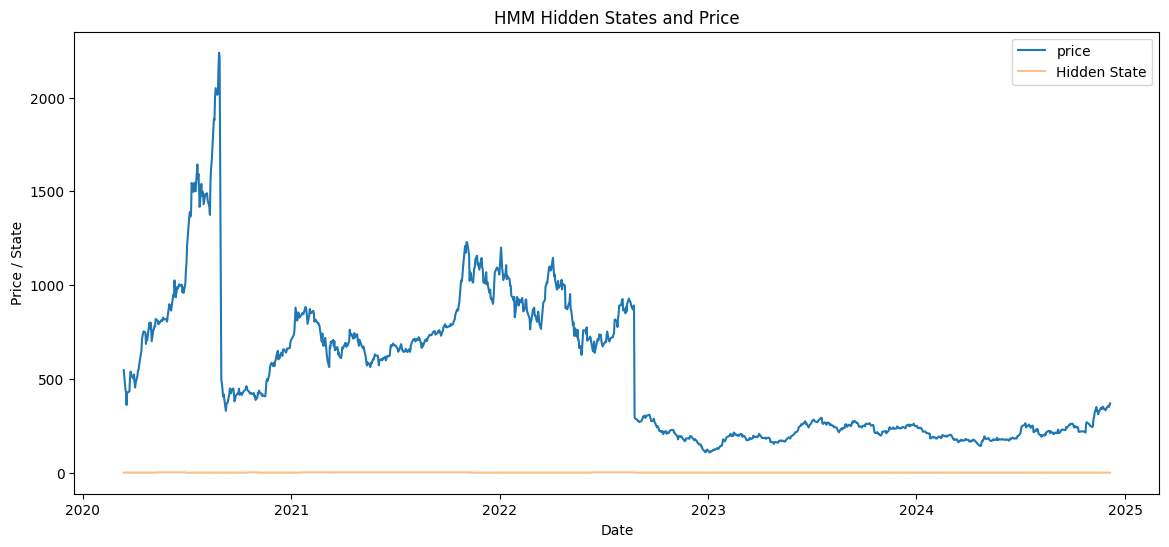

In [74]:
# Predict the hidden states
hidden_states = model.predict(X_quantized)

# Add the hidden states to the DataFrame
data['Hidden_State'] = hidden_states

# Analyze the characteristics of each state
state_means = data.groupby('Hidden_State')[features].mean()
print("State Means:\n", state_means)

# Visualize the hidden states and price
plt.figure(figsize=(14, 6))
plt.plot(data['close'], label='price')
plt.plot(data.index[0:], hidden_states, label='Hidden State', alpha=0.5)
plt.legend()
plt.title('HMM Hidden States and Price')
plt.xlabel('Date')
plt.ylabel('Price / State')
plt.show()


In [75]:
prediction_summary = predict_qualitative_return(model, hidden_states, state_means)
print(prediction_summary)

Current State: 0
Most Likely Next State: 1
Expect lower returns in the next period.


State Means:
                 Return  Volatility      SMA_50
Hidden_State                                  
0             0.009097    0.047342  472.045358
1            -0.006232    0.046907  475.755829
2             0.001864    0.034007  715.429913


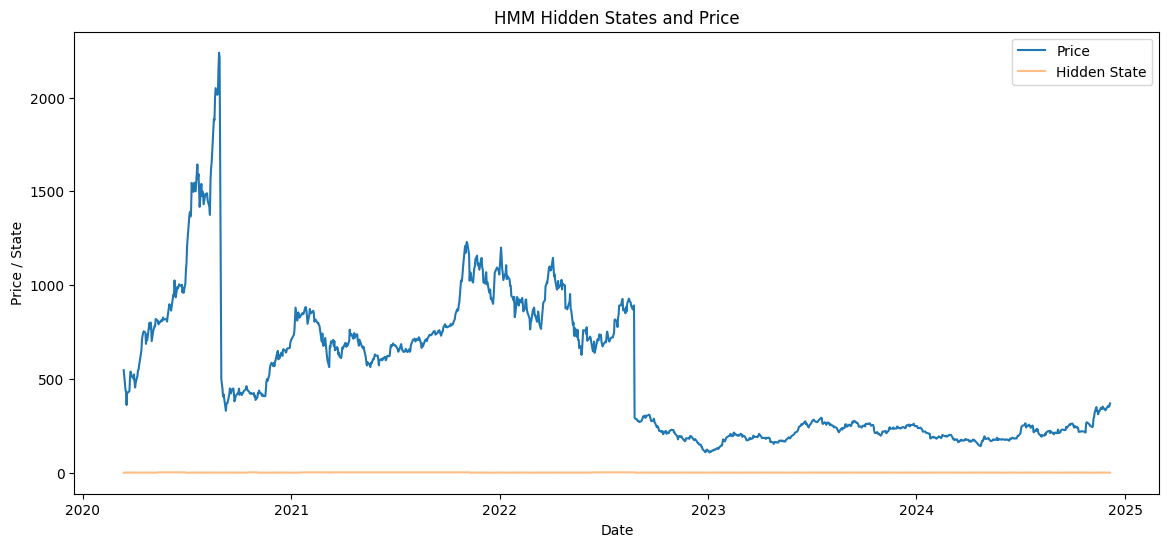

In [76]:
def load_and_preprocess_data(file_path):
    """
    Loads cryptocurrency data, calculates features, and handles missing values.

    Args:
        file_path (str): Path to the CSV file containing the data.

    Returns:
        pandas.DataFrame: DataFrame with preprocessed data.
    """
    data = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
    data['Return'] = data['close'].pct_change()
    data['Volatility'] = data['Return'].rolling(window=30).std()
    data['SMA_50'] = data['close'].rolling(window=50).mean()
    data = data.dropna()
    return data

def train_hmm(data, features, n_components):
    """
    Trains a Hidden Markov Model.

    Args:
        data (pandas.DataFrame): DataFrame containing the data.
        features (list): List of feature names to use for training.
        n_components (int): Number of hidden states.

    Returns:
        hmm.GaussianHMM: Trained HMM model.
        sklearn.preprocessing.QuantileTransformer: Fitted QuantileTransformer
    """
    from sklearn.preprocessing import QuantileTransformer
    X = data[features].values

    # QuantileTransformer to map to a uniform distribution and then to discrete values

    quantizer = QuantileTransformer(n_quantiles=n_components, output_distribution='uniform', random_state=0)
    X_quantized = quantizer.fit_transform(X)

    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", random_state=42)
    model.fit(X_quantized)  # Use the quantized features

    return model, quantizer


def predict_and_analyze_states(model, data, features, quantizer):
    """
    Predicts hidden states, analyzes their characteristics, and visualizes them.

    Args:
        model (hmm.GaussianHMM): Trained HMM model.
        data (pandas.DataFrame): DataFrame containing the data.
        features (list): List of feature names.
        quantizer (sklearn.preprocessing.QuantileTransformer): Fitted QuantileTransformer

    Returns:
        pandas.DataFrame: DataFrame with added 'Hidden_State' column.
    """
    X = data[features].values
    X_quantized = quantizer.transform(X)
    hidden_states = model.predict(X_quantized)
    data['Hidden_State'] = hidden_states

    state_means = data.groupby('Hidden_State')[features].mean()
    print("State Means:\n", state_means)

    plt.figure(figsize=(14, 6))
    plt.plot(data['close'], label='Price')
    plt.plot(data.index, hidden_states, label='Hidden State', alpha=0.5)
    plt.legend()
    plt.title('HMM Hidden States and Price')
    plt.xlabel('Date')
    plt.ylabel('Price / State')
    plt.show()

    return data

# Example usage:
file_path = '../csv/TSLA_from_2021.csv'
data = load_and_preprocess_data(file_path)
features = ['Return', 'Volatility', 'SMA_50']
n_components = 3
model, quantizer = train_hmm(data, features, n_components)
data = predict_and_analyze_states(model, data, features, quantizer)


In [77]:
  # "## Adapting the Model for Week-to-Week Predictions\n",
    # "\n",
    # "The current model is trained on daily data, so its transition matrix (`model.transmat_`) represents **day-to-day** state transitions. \n",
    # "\n",
    # "To analyze and predict **week-to-week** transitions, we must first resample our data to a weekly frequency. This involves aggregating the daily data points for each week and then recalculating our features on this new weekly timeframe. A new HMM would then be trained on this weekly data."


    # --- How to Adapt for Week-to-Week Predictions ---\n
    # To get weekly transition probabilities, we first need to resample the daily data to a weekly frequency.\n",
    # We need to decide how to aggregate the OHLCV data. A common way is:\n",
agg_dict = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'trade_count': 'sum',
}
weekly_data = data.resample('W').agg(agg_dict).dropna()

# Now, recalculate features on this new weekly timeframe
weekly_data['Return'] = weekly_data['close'].pct_change()
weekly_data['Volatility'] = weekly_data['Return'].rolling(window=4).std() # e.g., 4-week (monthly) volatility
weekly_data['SMA_10'] = weekly_data['close'].rolling(window=10).mean() # e.g., 10-week SMA

weekly_data = weekly_data.dropna()

print("--- Weekly Data Head ---")
print(weekly_data.head())
# You would then train a new HMM on this 'weekly_data' DataFrame.\n",
# The resulting model's transition matrix would represent week-to-week state changes.\n",
# For example:\n",
# features_weekly = ['Return', 'Volatility', 'SMA_10']\n",
# model_weekly, quantizer_weekly = train_hmm(weekly_data, features_weekly, n_components=3)"


--- Weekly Data Head ---
                             open       high     low   close      volume  \
timestamp                                                                  
2020-05-17 00:00:00+00:00  790.51   843.2900  763.30  799.17  76522302.0   
2020-05-24 00:00:00+00:00  827.78   834.7201  796.00  816.88  51565112.0   
2020-05-31 00:00:00+00:00  834.50   835.0000  785.00  835.00  39749489.0   
2020-06-07 00:00:00+00:00  858.00   908.6600  854.10  885.66  53990282.0   
2020-06-14 00:00:00+00:00  919.00  1027.4800  909.16  935.28  77820992.0   

                           trade_count    Return  Volatility   SMA_10  
timestamp                                                              
2020-05-17 00:00:00+00:00    1492421.0 -0.024713    0.100300  634.047  
2020-05-24 00:00:00+00:00    1016932.0  0.022160    0.093306  661.073  
2020-05-31 00:00:00+00:00     811809.0  0.022182    0.083890  701.820  
2020-06-07 00:00:00+00:00    1177693.0  0.060671    0.034942  738.950  
2020-06-14